**MPPI Optimization Loop Demo**

# **Installations**

In [124]:
# Clone the repository
import os
import sys

git_path = '/content/balloon-outreach'
if os.path.exists(git_path):
    print(":white_check_mark: Found:", git_path)
    sys.path.append('/content/balloon-outreach/')
    %cd balloon-outreach/
else:
    print(":x: Not found:", git_path)
    !git clone https://github.com/sdean-group/balloon-outreach.git
    %cd balloon-outreach
    !git checkout main

:white_check_mark: Found: /content/balloon-outreach
[Errno 2] No such file or directory: 'balloon-outreach/'
/content/balloon-outreach


In [2]:
# Install required packages
!pip install -r requirements.txt
!pip install -U gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 136.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 137.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.9 MB/s eta 0:00:00
  Created wheel for reverse_geocoder:

In [4]:
# Getting ERA5 data
from google.colab import drive
import gdown
import os

# 1. Mount your Drive
drive.mount('/content/drive')

# 2. Check existence
if os.path.exists('/content/drive/My Drive/era5_data.nc'):
    print("✅ Found:", '/content/drive/My Drive/era5_data.nc')
    datapath = '/content/drive/My Drive/era5_data.nc'

elif os.path.exists("/content/balloon-outreach/era5_data.nc"):
    print("✅ Found:", "/content/balloon-outreach/era5_data.nc")
    datapath = "/content/balloon-outreach/era5_data.nc"

else:
    print("❌ Not found")
    # Download ERA5 data
    file_id = "1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf"
    url = f"https://drive.google.com/uc?id={file_id}"
    output = "era5_data.nc"
    gdown.download(url, output, quiet=False)
    datapath = "/content/balloon-outreach/era5_data.nc"

Mounted at /content/drive
✅ Found: /content/drive/My Drive/era5_data.nc


In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import sys
from math import cos, radians
from datetime import datetime

In [7]:
# Ensure download worked
ds = xr.open_dataset(datapath, engine='netcdf4')
print(ds)

<xarray.Dataset> Size: 3GB
Dimensions:         (valid_time: 120, pressure_level: 7, latitude: 361,
                     longitude: 1440)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 960B 2024-07-01 ... 2024-07-0...
  * pressure_level  (pressure_level) float64 56B 1e+03 800.0 ... 200.0 100.0
  * latitude        (latitude) float64 3kB 90.0 89.75 89.5 ... 0.5 0.25 0.0
  * longitude       (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    expver          (valid_time) <U4 2kB ...
Data variables:
    u               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
    v               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
  

# **Sampling Demo**

Below is a walkthrough of one iteration of the MPPI optimization loop for a given control sequence. It has the objective of reaching a target:

In [119]:
os.chdir('/content/balloon-outreach')
sys.path.append('/content/balloon-outreach')

from env.balloon_env import BalloonERAEnvironment
from agent.mppi_agent import MPPIAgent
from env.visualize import plot_accs_vels_samples, plot_alts_movement_samples, plot_vels_averaged, plot_costs_samples

# Starting parameters - you can change these and explore the results! The visualizations are easiest to see if the target and inital point are somewhat close.
initial_lat = 0
initial_lon = 0
initial_alt = 10.0
target_lat = 1
target_lon = 1
target_alt = 12
horizon = 30 # how far ahead we should look for our plans
num_samples = 10 # how many control sequences to sample
acc_bounds = -0.5,0.5 # controls variety of sampled control sequences
dt = 600 # 600s

# Don't change this parameter (needs to match dataset’s first valid_time)
start_time = datetime(2024, 7, 1, 0, 0)

env = BalloonERAEnvironment(ds=ds, start_time=start_time, initial_lat=initial_lat, initial_lon=initial_lon, initial_alt=initial_alt, target_lat=target_lat, target_lon=target_lon,target_alt=target_alt,dt=dt, viz=False, add_noise=False)
agent = MPPIAgent(horizon=horizon,num_samples=num_samples, acc_bounds=acc_bounds, visualize=False)


control_sequence = np.zeros(horizon) # our plan of velocities for the balloon - we start with 0s

# 1. Sample random control sequences
vertical_velocity = env.balloon.vertical_velocity
base_sequence = control_sequence.copy()
# Add noise from a Normal distribution to create samples
noise = np.random.normal(0, agent.noise_std, (agent.num_samples, agent.horizon))

acc_samples = base_sequence + noise
acc_samples = np.clip(acc_samples, agent.acc_bounds[0], agent.acc_bounds[1])

accumulated_acc_samples = np.cumsum(acc_samples, axis=1)
vel_samples = vertical_velocity + accumulated_acc_samples

# Clip to action bounds
vel_samples = np.clip(vel_samples, agent.vel_bounds[0], agent.vel_bounds[1])


WindField initialized with noise enabled: False


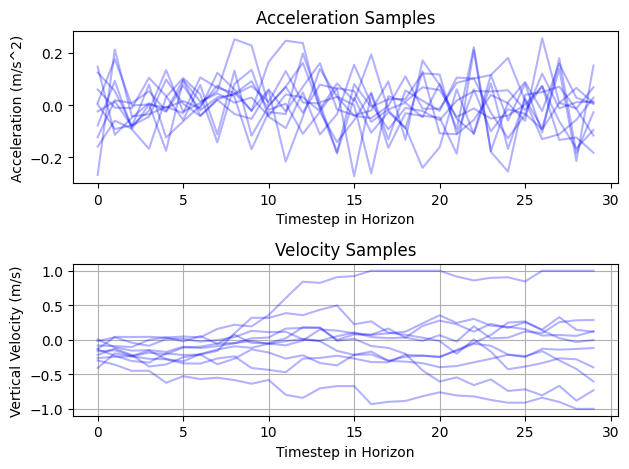

In [120]:
# Visualize the sampled accelerations and resulting velocity sequences
plot_accs_vels_samples(acc_samples, vel_samples, horizon)

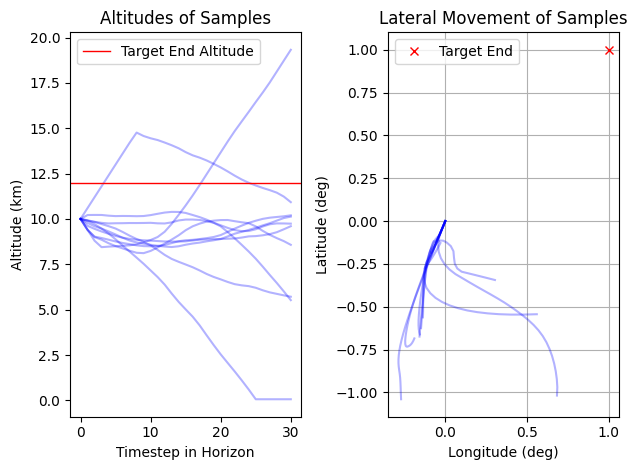

In [121]:
# Use sampled vertical velocities to track horizontal and vertical movement
vert_movement = []
lateral_movement = []
for sample in vel_samples:
  # Paths for one sample
  alts = []
  paths = []
  alts.append(env.balloon.alt)
  paths.append((env.balloon.lat, env.balloon.lon))
  for action in sample:
    state, reward, done, reason = env.step(action)
    alts.append(env.balloon.alt)
    paths.append((env.balloon.lat, env.balloon.lon))
  # Add the paths to the overall list
  vert_movement.append(alts)
  lateral_movement.append(paths)
  env.reset() # Resetting the environment to original location to rollout next sampled velocity sequence

# You should see a variety of possible altitudes the balloon could have, which leads to different lateral movement
plot_alts_movement_samples(vert_movement, lateral_movement, horizon, target_state=[target_lat,target_lon,target_alt])

In optimization, we always want to *reduce* the cost of our plan. So a smaller cost for a sampled control sequence means it is better (gets us closer to our target), so it should have more weight.

Costs are: [46.66499458 57.70263688 30.6731982  54.55997096 29.2135014  58.40226708
 51.65234227 40.67650375 56.82421716 53.77889768]
Weights are: [2.13889904e-08 3.44035409e-13 1.88512092e-01 7.96976670e-12
 8.11479357e-01 1.70906118e-13 1.45952892e-10 8.53019210e-06
 8.28125157e-13 1.74044950e-11]


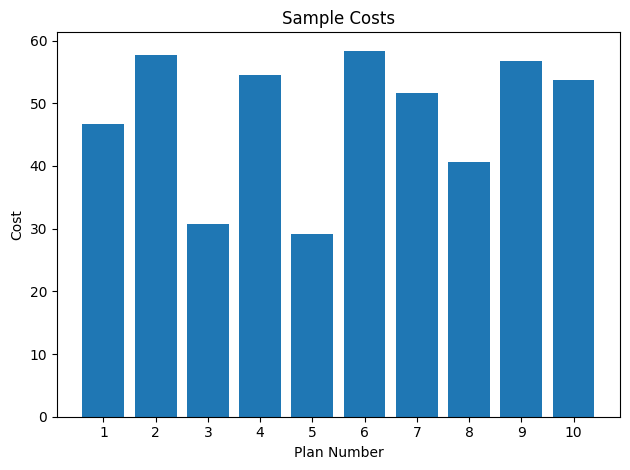

In [122]:

# 2. Calculate cost of each sequence.
# Note: The cost is how far our current position is from the target position.
# It's calculated in the environment using Haversine distance (used for calculating points on a sphere instead of Euclidean distance)
costs = []
for i in range(num_samples):
    # Evaluate one sample control sequence
    cost = 0.0
    vel_sample = vel_samples[i]
    acc_sample = acc_samples[i]

    cost, _ = agent._evaluate_control_sequence(acc_sample,vel_sample, [], env)
    costs.append(cost)

costs = np.array(costs)

# Check for NaN costs and replace with high cost
if np.any(~np.isfinite(costs)):
    print("Warning: NaN costs detected, replacing with high cost")
    costs = np.where(np.isfinite(costs), costs, 1e6)
print(f"Costs are: {costs}")

# 3. Use the costs to calculate weights for each sampled sequence
# Shift costs to prevent numerical issues
costs_shifted = costs - np.min(costs)

# Compute weights using softmax
weights = np.exp(-1 * costs_shifted)
weights = weights / np.sum(weights)

# Check for NaN weights
if np.any(~np.isfinite(weights)):
    print("Warning: NaN weights detected, using uniform weights")
    weights = np.ones_like(weights) / len(weights)
print(f"Weights are: {weights}")

# Graph the costs. If the trajectories are similar, the costs and weights will also be similar
plot_costs_samples(costs)

Final control sequence: [-0.23490235 -0.171327   -0.26357647 -0.39896358 -0.40732318 -0.30540656
 -0.27983249 -0.3919112  -0.33247216 -0.23327316 -0.25902106 -0.37130232
 -0.34035778 -0.40554116 -0.42769642 -0.30270005 -0.34842042 -0.41732147
 -0.42381483 -0.42933032 -0.46558627 -0.46052636 -0.41957747 -0.38723735
 -0.34894369 -0.36408935 -0.29199932 -0.41195134 -0.53115992 -0.67881836]


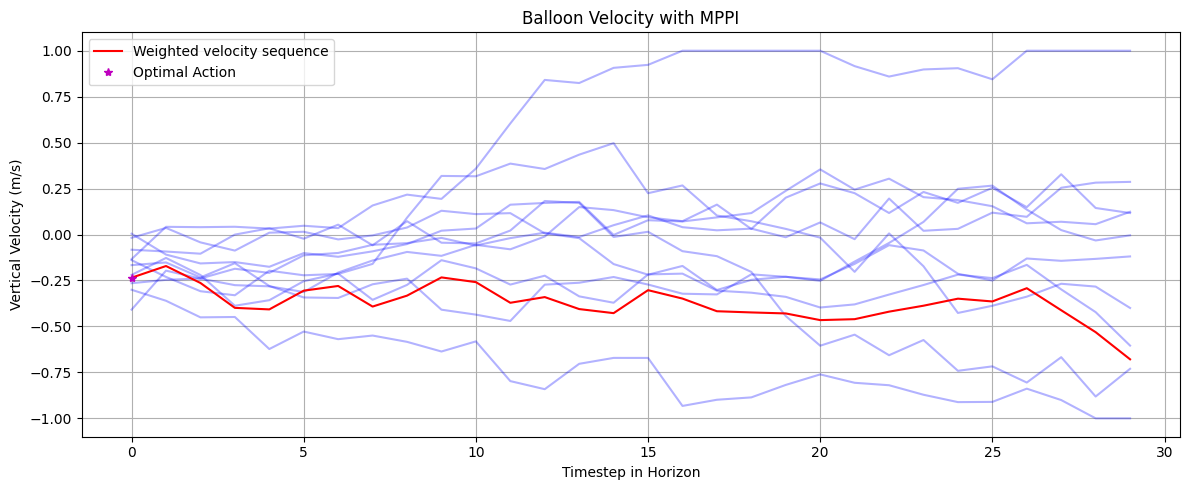

In [123]:
# 4. Compute optimal control sequence by weighted averaging
optimal_sequence = np.average(vel_samples, axis=0, weights=weights)
# Check for NaN in optimal control
if not np.isfinite(optimal_sequence[0]):
    print("Warning: NaN optimal control detected, using zero action")
    optimal_sequence[0] = 0.0

# 5. Update control sequence
control_sequence = optimal_sequence

print(f"Final control sequence: {control_sequence}")
# Plot sequences
plot_vels_averaged(vel_samples, control_sequence, horizon)

The graph should change slightly each time you run this section since the generated samples are random. The optimal action the agent selects is the first velocity from the control sequence.

# **Iterative Optimization**

MPPI normally optimizes once per timestep. However, we can repeat this optimization loop `num_iterations` times to try to get a better control sequence. For each loop, once we get the optimal control sequence, we pass this in as the initial control sequence to re-optimize.

WindField initialized with noise enabled: False


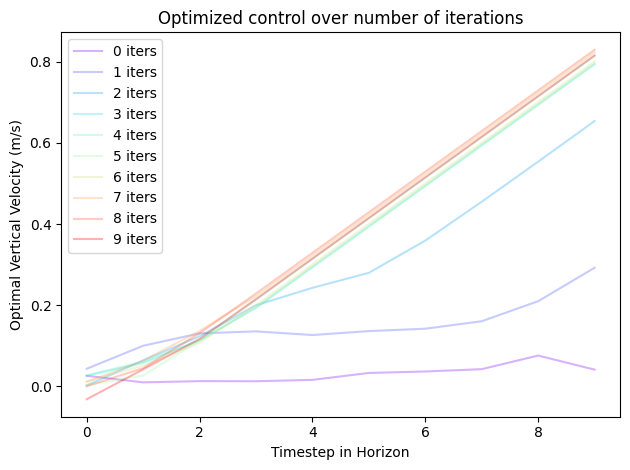

In [125]:
from matplotlib.pyplot import cm

# Optional: Modify the MPPI parameters. Note that at this starting point (Ithaca) the winds are northwest
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0
target_lat = 60
target_lon = -83
# Note: increasing any of the below three parameters will cause this cell to run longer, but could benefit performance
horizon = 10 # how far ahead we look for our planning.
num_samples = 10 # how many random plans should we make
num_iterations = 10 # how many times should we make the random plans
acc_bounds = -0.1,0.1
dt = 600 # 600s

# Don't change this parameter (needs to match dataset’s first valid_time)
start_time = datetime(2024, 7, 1, 0, 0)

env = BalloonERAEnvironment(ds=ds, start_time=start_time, initial_lat=initial_lat, initial_lon=initial_lon, initial_alt=initial_alt, target_lat=target_lat, target_lon=target_lon,dt=dt, viz=False, add_noise=False)
agent = MPPIAgent(horizon=horizon,num_samples=num_samples, num_iterations=num_iterations, acc_bounds=acc_bounds, visualize=False)

# Initializations
control_sequence = np.zeros(horizon)
env.balloon.vertical_velocity = 0.0
first_sequence = control_sequence
color = iter(cm.rainbow(np.linspace(0, 1, agent.num_iterations)))
all_costs = []

# Repeat optimization loop
for num in range(num_iterations):
  vertical_velocity = env.balloon.vertical_velocity
  base_sequence = control_sequence.copy()
  # Add noise from a Normal distribution to create samples
  noise = np.random.normal(0, agent.noise_std, (agent.num_samples, agent.horizon))

  acc_samples = base_sequence + noise
  acc_samples = np.clip(acc_samples, agent.acc_bounds[0], agent.acc_bounds[1])

  accumulated_acc_samples = np.cumsum(acc_samples, axis=1)
  vel_samples = vertical_velocity + accumulated_acc_samples

  # Clip to action bounds
  vel_samples = np.clip(vel_samples, agent.vel_bounds[0], agent.vel_bounds[1])
  costs = []
  for i in range(num_samples):
      # Evaluate one sample control sequence
      cost = 0.0
      vel_sample = vel_samples[i]
      acc_sample = acc_samples[i]

      cost, _ = agent._evaluate_control_sequence(acc_sample,vel_sample, [], env)
      costs.append(cost)

  costs = np.array(costs)
  all_costs.append(np.mean(costs)) # Track average cost for each sample

  # Check for NaN costs and replace with high cost
  if np.any(~np.isfinite(costs)):
      print("Warning: NaN costs detected, replacing with high cost")
      costs = np.where(np.isfinite(costs), costs, 1e6)

  # Calculate weights with softmax
  costs_shifted = costs - np.min(costs)
  weights = np.exp(-1 * costs_shifted)
  weights = weights / np.sum(weights)

  # Check for NaN weights
  if np.any(~np.isfinite(weights)):
      print("Warning: NaN weights detected, using uniform weights")
      weights = np.ones_like(weights) / len(weights)

  optimal_sequence = np.average(vel_samples, axis=0, weights=weights)
  # Check for NaN in optimal control
  if not np.isfinite(optimal_sequence[0]):
      print("Warning: NaN optimal control detected, using zero action")
      optimal_sequence[0] = 0.0

  control_sequence = optimal_sequence
  if num == 1:
    # Save the first optimized sequence. We will compare this to the final optimized sequence after more iterations
    first_sequence = control_sequence
  c = next(color)
  pltlabel = f"{num} iters"
  plt.plot(control_sequence, c=c, alpha=0.3, label=pltlabel)
  #print(f"Optimized control sequence: {control_sequence}")

plt.title('Optimized control over number of iterations')
plt.xlabel('Timestep in Horizon')
plt.ylabel('Optimal Vertical Velocity (m/s)')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

Try to adjust the `num_iterations` variable to see how the optimized control sequence changes! Does it seem to converge?

Below are some visualizations to see how costs and trajectories changed with these iterations.

The minimum averaged cost is 151.00182863592633
Minimum averaged cost control sequence: Plan 3


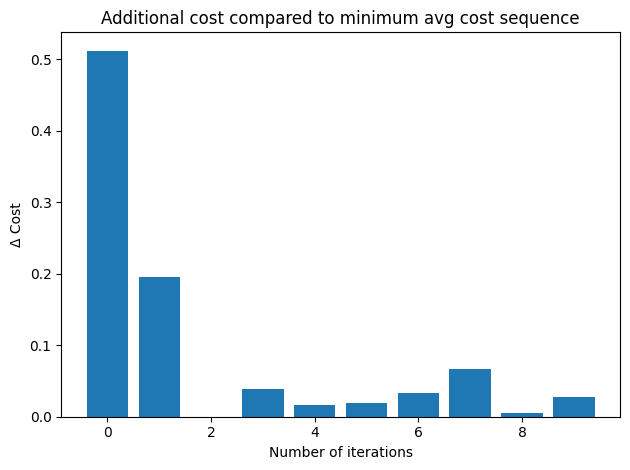

In [126]:
# Save first and last averaged cost for next section
first_cost = all_costs[0]
last_cost = all_costs[len(all_costs)-1]

# Graph differences in averaged costs
print(f"The minimum averaged cost is {min(all_costs)}")
all_costs = all_costs - min(all_costs)
all_costs = np.array(all_costs)
print(f"Minimum averaged cost control sequence: Plan {np.argmin(all_costs) + 1}")
plt.bar([i for i in range(agent.num_iterations)], all_costs)
plt.title('Additional cost compared to minimum avg cost sequence')
plt.xlabel('Number of iterations')
plt.ylabel('Δ Cost')
plt.tight_layout()
plt.show()
plt.close()

In [127]:
# Get rollouts of the first and last optimized trajectory
env.reset()
lateral_movement = []
print(f"First control sequence: {first_sequence}")
print(f"Last control sequence: {control_sequence}")
for sample in [first_sequence, control_sequence]:

  paths = []
  paths.append(( env.balloon.lat, env.balloon.lon))
  for action in sample:
    state, reward, done, reason = env.step(action)
    paths.append((env.balloon.lat, env.balloon.lon))
  lateral_movement.append(paths)
  env.reset() # Resetting environment to start balloon back at inital spot for next sequence to evaluate

First control sequence: [0.04358576 0.10020783 0.13070872 0.13570249 0.12669362 0.13637876
 0.14223349 0.1606579  0.20997378 0.29231352]
Last control sequence: [-0.03142259  0.04218654  0.11700625  0.21489011  0.31489011  0.41489011
  0.51489011  0.61489011  0.71489011  0.81489011]


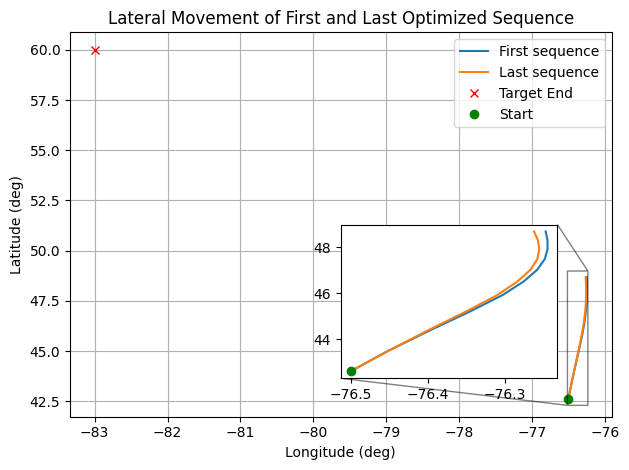

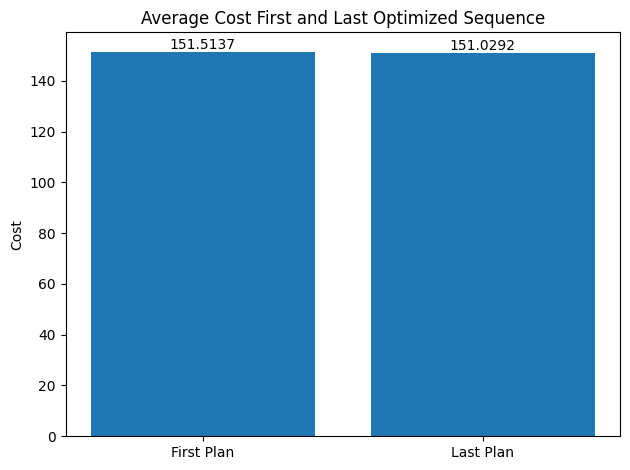

In [160]:
# Closer comparison of trajectories of first and last optimized sequences
fig, ax = plt.subplots()

lats, lons = zip(*lateral_movement[0])
ax.plot(lons, lats, label='First sequence')
lats2, lons2 = zip(*lateral_movement[1])
ax.plot(lons2, lats2, label='Last sequence')
target_state = [target_lat,target_lon]
# Plotting the target point and legend
if target_state is not None:
  ax.plot(target_state[1],target_state[0], 'rx', label='Target End')
  ax.plot(initial_lon, initial_lat, 'go', label='Start')
  ax.legend()

  fig.canvas.draw()  # force layout

  # Dynamic subgraph positioning
  # Data coords → display (pixels)
  target_disp = ax.transData.transform((target_state[1], target_state[0]))
  # Display → axes fraction
  target_axes_coords = ax.transAxes.inverted().transform(target_disp)
  tx, ty = target_axes_coords

  # Draw inset graph in opposite corner
  if tx >= 0.5 and ty >= 0.5:
      inset_x0, inset_y0 = 0.2, 0.1  # bottom-left
  elif tx < 0.5 and ty >= 0.5:
      inset_x0, inset_y0 = 0.5, 0.1  # bottom-right
  elif tx >= 0.5 and ty < 0.5:
      inset_x0, inset_y0 = 0.2, 0.5  # top-left
  else:
      inset_x0, inset_y0 = 0.5, 0.5  # top-right
else:
  inset_x0, inset_y0 = 0.1, 0.5

plt.title(f'Lateral Movement of First and Last Optimized Sequence')
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')


# Inset Axes (the subgraph)
axins = ax.inset_axes([inset_x0, inset_y0, 0.4, 0.4]) # describes coordinates for where the subgraph should be displayed. Bounds are: [x0,y0,width,height]
axins.plot(lons, lats) # plots first trajectory
axins.plot(lons2, lats2) # plots last trajectory
axins.plot(initial_lon, initial_lat, 'go')
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

# Plot the two costs
bars = plt.bar(['First Plan', 'Last Plan'], [first_cost, last_cost])
plt.bar_label(bars, [f"{first_cost:.4f}", f"{last_cost:.4f}"])
plt.title(f'Average Cost First and Last Optimized Sequence')
plt.ylabel('Cost')
plt.tight_layout()
plt.show()
plt.close()